In [1]:
import os
os.environ['HF_HOME'] = '/workspace/huggingface'

from transformer_lens import HookedTransformer, ActivationCache, utils
import torch

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

Device: cuda


In [2]:
model = HookedTransformer.from_pretrained('gpt2', device=device)

model.eval()
model.set_use_attn_result(True)
model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Loaded pretrained model gpt2 into HookedTransformer


In [13]:
clean_prompt = '''I'm Davide and I'm 20 years old.
{
    "name": "Davide",
    "age": 20
}

I'm Paul and I'm 12 years old.
{
    "name": "Paul",
    "age": 12
}

I'm Sarah and I'm 25 years old.
{
    "name": "'''

corrupted_prompt = '''I'm Davide and I'm 20 years old.
{
    "name": "Davide",
    "age": 20
}

I'm Paul and I'm 12 years old.
{
    "name": "Paul",
    "age": 12
}

I'm Laura and I'm 25 years old.
{
    "name": "'''

In [14]:
print(model.generate(corrupted_prompt, 1, stop_at_eos=False))

  0%|          | 0/1 [00:00<?, ?it/s]

I'm Davide and I'm 20 years old.
{
    "name": "Davide",
    "age": 20
}

I'm Paul and I'm 12 years old.
{
    "name": "Paul",
    "age": 12
}

I'm Laura and I'm 25 years old.
{
    "name": "Laura


### AtP

In [15]:
import os
import sys

current_dir = os.getcwd()
atp_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
sys.path.append(atp_dir)

from atp import Patching

patching = Patching(model, 'atp')

In [16]:
x_clean = clean_prompt
x_corr = corrupted_prompt

a_clean = 'Sarah'
a_corr = 'Laura'

patching.patching(x_clean, a_clean, x_corr, a_corr, component='attn_all')

Clean logit difference: 11.632
Corrupted logit difference: -10.022
Patching...


In [17]:
fig = patching.plot()
fig.write_html("fig.html")

Promoting heads: L8H11, L9H6, L9H9, L10H0, L10H1, L10H10

Suppression heads: L10H7, L10H11

In [32]:
prompt = '''I'm Davide and I'm 20 years old.
{
    "name": "Davide",
    "age": 20
}

I'm Paul and I'm 12 years old.
{
    "name": "Paul",
    "age": 12
}'''

In [33]:
def logits_diff(logits, ans):
    top_tokens = logits[0, -1].topk(5).indices.tolist()
    if isinstance(ans, str):
        ans = model.to_single_token(ans)

    if ans in top_tokens:
        top_tokens.remove(ans)
        
    return logits[0, -1, ans] - logits[0, -1, top_tokens].mean(-1)
    
def get_cache_fwd_and_bwd(tokens, ans):
        filter_not_qkv_input = lambda name: "_input" not in name
        model.reset_hooks()
        cache = {}

        def forward_cache_hook(act, hook):
            cache[hook.name] = act.detach()

        model.add_hook(filter_not_qkv_input, forward_cache_hook, "fwd")

        grad_cache = {}

        def backward_cache_hook(act, hook):
            grad_cache[hook.name] = act.detach()

        model.add_hook(filter_not_qkv_input, backward_cache_hook, "bwd")

        value = logits_diff(model(tokens), ans)
        value.backward()
        model.reset_hooks()
        return (
            value.item(),
            ActivationCache(cache, model),
            ActivationCache(grad_cache, model),
        )

In [34]:
tokens = model.to_tokens(prompt)
list(enumerate(model.to_str_tokens(prompt)))

[(0, '<|endoftext|>'),
 (1, 'I'),
 (2, "'m"),
 (3, ' Dav'),
 (4, 'ide'),
 (5, ' and'),
 (6, ' I'),
 (7, "'m"),
 (8, ' 20'),
 (9, ' years'),
 (10, ' old'),
 (11, '.'),
 (12, '\n'),
 (13, '{'),
 (14, '\n'),
 (15, ' '),
 (16, ' '),
 (17, ' '),
 (18, ' "'),
 (19, 'name'),
 (20, '":'),
 (21, ' "'),
 (22, 'D'),
 (23, 'av'),
 (24, 'ide'),
 (25, '",'),
 (26, '\n'),
 (27, ' '),
 (28, ' '),
 (29, ' '),
 (30, ' "'),
 (31, 'age'),
 (32, '":'),
 (33, ' 20'),
 (34, '\n'),
 (35, '}'),
 (36, '\n'),
 (37, '\n'),
 (38, 'I'),
 (39, "'m"),
 (40, ' Paul'),
 (41, ' and'),
 (42, ' I'),
 (43, "'m"),
 (44, ' 12'),
 (45, ' years'),
 (46, ' old'),
 (47, '.'),
 (48, '\n'),
 (49, '{'),
 (50, '\n'),
 (51, ' '),
 (52, ' '),
 (53, ' '),
 (54, ' "'),
 (55, 'name'),
 (56, '":'),
 (57, ' "'),
 (58, 'Paul'),
 (59, '",'),
 (60, '\n'),
 (61, ' '),
 (62, ' '),
 (63, ' '),
 (64, ' "'),
 (65, 'age'),
 (66, '":'),
 (67, ' 12'),
 (68, '\n'),
 (69, '}')]

In [74]:
import einops
from tqdm import tqdm

first_output_token_id = 48

patch = torch.zeros(144, len(tokens[0]) - first_output_token_id)

for i in tqdm(range(first_output_token_id, len(tokens[0]))):
    _, cache, grad_cache = get_cache_fwd_and_bwd(tokens[:, :i], tokens[0, i])

    act = cache.stack_head_results(-1)
    grad_act = grad_cache.stack_head_results(-1)

    patch[:, i-first_output_token_id] = einops.reduce(
                grad_act *  act,
                "component batch pos d_model -> component pos",
                "sum",
            )[:, -1]

100%|██████████| 22/22 [00:02<00:00,  8.08it/s]


In [75]:
patch.shape

torch.Size([144, 22])

In [76]:
import plotly.express as px
ys = [f'L{i}H{j}' for i in range(model.cfg.n_layers) for j in range(model.cfg.n_heads)]
xs = [f"{tok} | {i}" for i, tok in enumerate(model.to_str_tokens(prompt)[first_output_token_id:])]

fig = px.imshow(
    patch.cpu().numpy(), 
    x=xs,
    y=ys,
    title=f"Patching results for AtP method",
    color_continuous_scale='RdBu', zmin=-1, zmax=1, aspect='auto'
)
fig.write_html("fig.html")

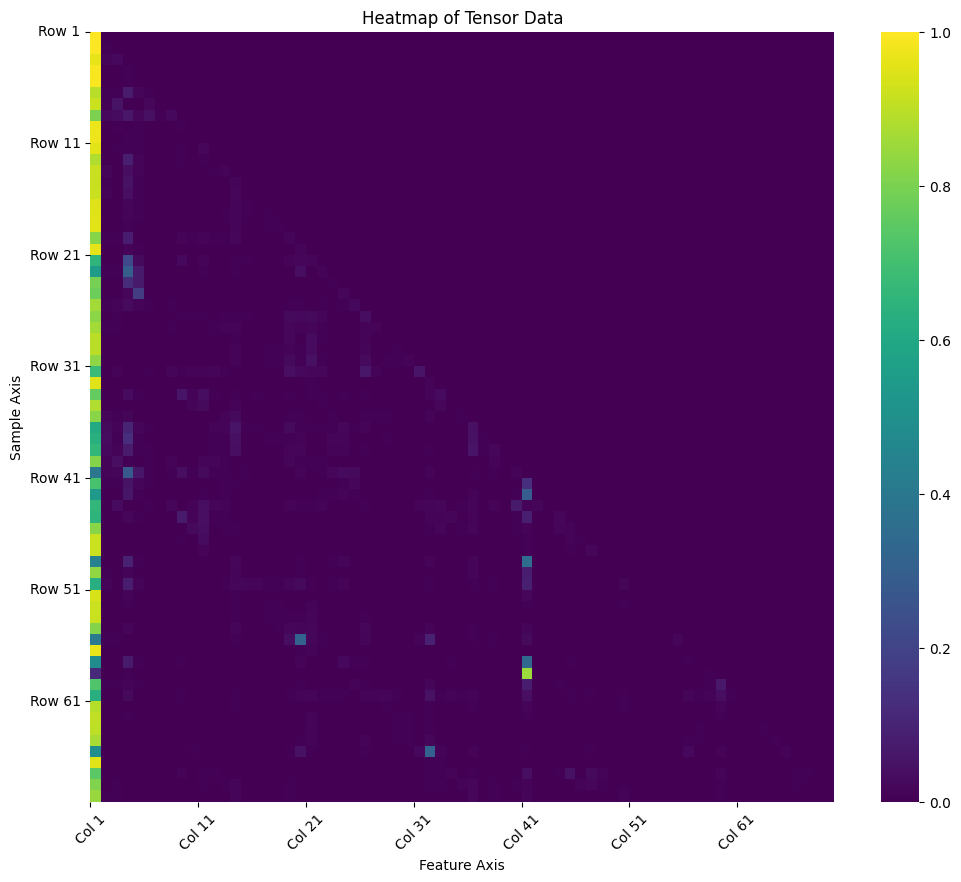

In [84]:
import seaborn as sns
layer_id = 10
head_id = 6

data = cache[f'blocks.{layer_id}.attn.hook_pattern'][0, head_id].cpu()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
ax = sns.heatmap(data, cmap='viridis')

# Set tick labels
ax.set_xticks(range(0, data.shape[1], 10))  # Set x-ticks every 10 columns
ax.set_yticks(range(0, data.shape[0], 10))  # Set y-ticks every 10 rows

# Set tick labels with optional custom labeling
ax.set_xticklabels([f"Col {i+1}" for i in range(0, data.shape[1], 10)])
ax.set_yticklabels([f"Row {i+1}" for i in range(0, data.shape[0], 10)])

# Rotate tick labels for better visibility
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Title and labels (optional)
plt.title('Heatmap of Tensor Data')
plt.xlabel('Feature Axis')
plt.ylabel('Sample Axis')

# Show the plot
plt.show()

## SAEs

In [69]:
from huggingface_hub import snapshot_download

REPO_ID = "jbloom/GPT2-Small-SAEs-Reformatted"
path = snapshot_download(repo_id=REPO_ID)

Fetching 41 files:   0%|          | 0/41 [00:00<?, ?it/s]

In [ ]:
from sae_lens import LMSparseAutoencoderSessionloader
from tqdm import tqdm
import os

saes = []

for l in tqdm(range(model.cfg.n_layers)):
    model, sae_group, activation_store = LMSparseAutoencoderSessionloader.load_pretrained_sae(
        path = os.path.join(path, f"blocks.{l}.hook_resid_pre"), device=device
    )
    sae_group.eval()
    saes.append(sae_group[f'blocks.{l}.hook_resid_pre'])

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning:

The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.



  8%|▊         | 1/12 [00:37<06:54, 37.66s/it]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning:

The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.

 17%|█▋        | 2/12 [00:50<03:52, 23.29s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 25%|██▌       | 3/12 [01:00<02:32, 16.94s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 33%|███▎      | 4/12 [01:07<01:44, 13.03s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 42%|████▏     | 5/12 [01:18<01:27, 12.43s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 50%|█████     | 6/12 [01:26<01:04, 10.77s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 58%|█████▊    | 7/12 [01:52<01:19, 15.82s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 67%|██████▋   | 8/12 [01:59<00:52, 13.05s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


In [23]:
json_text = """{
    "question": "What's the capital of France?",
    "answer": Paris
    }"""

non_json_text = [
    """What's the capital of France?
Paris""",
    """These are the things I love:
1. Food,
2. Sea,
3. Friends""",
    """An old man once told me: "You will succeed in life".
I hope him to be true."""
]

In [7]:
features_dict = {l: [] for l in range(model.cfg.n_layers)}

with open("json_features.txt", "r") as f:
    features = f.readlines()

for f in features:
    f = f.strip().split('-')
    layer = int(f[0])
    features_dict[layer].append(f[1])

In [26]:
features_act_dict = {
    'L': [],
    'N': [],
    'JSON Activation': [],
    'Non-JSON Activation': []
}

with torch.no_grad():
    _, json_cache = model.run_with_cache(model.to_tokens(json_text))
    _, non_json_cache = model.run_with_cache(model.to_tokens(non_json_text[2]))

for l in range(model.cfg.n_layers):
    json_activations = json_cache[f'blocks.{l}.hook_resid_pre'] # [1 p dm]
    non_json_activations = non_json_cache[f'blocks.{l}.hook_resid_pre'] # [1 p dm]

    with torch.no_grad():
        _, json_features_act, *_ = saes[l](json_activations)
        _, non_json_features_act, *_ = saes[l](non_json_activations)

    for f in features_dict[l]:
        f = int(f)
        features_act_dict['L'].append(l)
        features_act_dict['N'].append(f)
        val, ix = json_features_act[0, :, f].max(0)
        features_act_dict['JSON Activation'].append([val.item(), ix.item()])
        val, ix = non_json_features_act[0, :, f].max(0)
        features_act_dict['Non-JSON Activation'].append([val.item(), ix.item()])        

In [27]:
import pandas as pd

pd.DataFrame(features_act_dict)

,L,N,JSON Activation,Non-JSON Activation
0,0,23622,"[0.0, 0]","[0.0, 0]"
1,1,5310,"[20.185184478759766, 8]","[0.0, 0]"
2,2,10521,"[25.650108337402344, 8]","[0.0, 0]"
3,4,21672,"[3.7655177116394043, 9]","[0.0, 0]"
4,4,8148,"[1.687551736831665, 18]","[0.0, 0]"
5,6,5682,"[24.25801658630371, 23]","[0.0, 0]"
6,6,3596,"[21.313154220581055, 2]","[0.0, 0]"
7,6,13428,"[0.9894517660140991, 8]","[0.0, 0]"
8,6,2164,"[0.0, 0]","[0.0, 0]"
9,7,20690,"[25.253623962402344, 23]","[0.0, 0]"


In [21]:
list(enumerate(model.to_str_tokens(json_text)))

[(0, '<|endoftext|>'),
 (1, '{'),
 (2, '\n'),
 (3, ' '),
 (4, ' '),
 (5, ' '),
 (6, ' "'),
 (7, 'question'),
 (8, '":'),
 (9, ' "'),
 (10, 'What'),
 (11, "'s"),
 (12, ' the'),
 (13, ' capital'),
 (14, ' of'),
 (15, ' France'),
 (16, '?",'),
 (17, '\n'),
 (18, ' '),
 (19, ' '),
 (20, ' '),
 (21, ' "'),
 (22, 'answer'),
 (23, '":'),
 (24, ' Paris'),
 (25, '\n'),
 (26, ' '),
 (27, ' '),
 (28, ' '),
 (29, ' }')]